# Design Thinking Project Task 3
The world will need to feed 9 billion people by 2050 (Godfray et. al 2010), and to do so through safe, sustainable food chains. Access by all – especially the poor and vulnerable – to safe, nutritious, and sufficient food is an issue of increasing urgency and a key Sustainable Development Goal. You are to help the United Nations and World Health Organisation make a model that can address the food security or food safety issue identified.

### Student Submission

Student's Name 

- Gangesh Kumar (1007181)
- Zhuang Yang Kun (1006933)
- Christabel Lim (1007042)
- Ernest Tan Wei Yan (1006883) 
- Ng Wan Qing (1007033)


### Quick Access to Each Section for Task 3

- [Problem Statement](#problem-statement)
- [Dataset](#Dataset)
- [Visualization of Dataset](#Visualization-of-Dataset)
- [Features and Target Selection](#Features-and-Target-Selection)
- [Multiple Linear Regression Model](#multiple-linear-Regression-Model)
- [Training Model 1](#Training-Model-1)
- [Training Model 2](#Training-Model-2)
- [Training Model 3](#Training-Model-3)
- [Function to predict crop type that has highest yield based on user input](#function-to-predict-crop-type-that-has-highest-yield-based-on-user-input)
- [Conclusion](#conclusion)
- [Video Link](#video-link)




### Requirements
Import the below packages. If an error of "module not found" is shown, use the following commands in your command prompt or Windows Powershell.

- pip install numpy
- pip install pandas
- pip install matplotlib.pyplot
- pip install seaborn
- pip install rapidfuzz

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# from rapidfuzz import process, fuzz
import json

### Defining Functions to simplify procedure for MLR model

In [53]:
def normalize_z(dfin, columns_to_normalize=None, columns_means=None, columns_stds=None):
    if columns_means is None:
        columns_means = dfin.mean(axis=0)
    if columns_stds is None:
        columns_stds = dfin.std(axis=0)
    
    if columns_to_normalize is None:
        # If columns_to_normalize is not specified, normalize all columns
        columns_to_normalize = dfin.columns

    # Normalize selected columns using z-score formula
    dfout = dfin.copy()  # Create a copy to avoid modifying the original DataFrame
    dfout[columns_to_normalize] = (dfin[columns_to_normalize] - columns_means[columns_to_normalize]) / columns_stds[columns_to_normalize]
    
    return dfout, columns_means, columns_stds
    
def get_features_targets(df, feature_names, target_names):
    df_features = df[feature_names]
    df_target = df[target_names]
    df_feature_np_array = df.to_numpy()
    return df_features, df_target

def prepare_feature(df_feature):
    if isinstance(df_feature, pd.DataFrame):
        df_feature_np_array = df_feature.to_numpy()
    else:
        df_feature_np_array = df_feature
    df_feature_np_array = np.insert(df_feature_np_array,0,1,axis=1)
    return df_feature_np_array


def prepare_target(df_target):
    if isinstance(df_target, pd.DataFrame):
        df_target_np_array = df_target.to_numpy()
    else:
        df_target_np_array = df_target
    return df_target_np_array

def predict_linreg(df_feature, beta, means=None, stds=None, columns_to_normalize=None):
    if columns_to_normalize is None:
        # If columns_to_normalize is not specified, normalize all columns
        columns_to_normalize = df_feature.columns
    if means is None or stds is None:
        df_feature_normalized, means, stds = normalize_z(df_feature,columns_to_normalize)
    else:
        df_feature_normalized,_,_ = normalize_z(df_feature,columns_to_normalize,means,stds)
    df_feature_normalized = prepare_feature(df_feature_normalized)
    y_pred_array = calc_linreg(df_feature_normalized, beta)
    return y_pred_array

def calc_linreg(X, beta):
    return np.matmul(X,beta)

def compute_cost_linreg(X, y, beta):
    J = 0
    y_pred_array = calc_linreg(X, beta)
    rows,columns = y.shape
    error_np_array = np.subtract(y_pred_array,y)
    error_np_array = np.square(error_np_array)
    J = np.sum(error_np_array)
    J = (J/rows)*0.5
    return J

def gradient_descent_linreg(X, y, beta, alpha, num_iters):
    iter_count = 0
    J_storage = []
    while iter_count < num_iters:
        rows,columns = y.shape
        X_transpose = np.transpose(X)
        error_np_array = np.subtract(calc_linreg(X, beta),y)
        descent_step_array = (alpha/rows)*(np.matmul(X_transpose, error_np_array))     
        beta = beta - descent_step_array
        J_storage.append(compute_cost_linreg(X, y, beta))
        iter_count+=1
    return beta, J_storage

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    np.random.seed(random_state)
    
    # Get the indices for test data
    num_samples = len(df_feature)
    num_test_samples = int(test_size * num_samples)
    test_indices = np.random.choice(num_samples, num_test_samples, replace=False)
    # Create train and test sets for features and target
    df_feature_test = df_feature.iloc[test_indices]
    df_target_test = df_target.iloc[test_indices]
    df_feature_train = df_feature.drop(test_indices)
    df_target_train = df_target.drop(test_indices)
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    y_mean = np.mean(y)
    ssRes = np.sum(np.square(np.subtract(y,ypred)))
    ssTot = np.sum(np.square(y - y_mean))
    return 1 - (ssRes/ssTot)

def mean_squared_error(target, pred):
    return np.mean(np.square(np.subtract(target,pred)))

## Problem Statement
In the current context, global prevalence of moderate or severe food insecurity has been slowly on the rise since 2014, and World Food Programme estimates that more than 333 million people are facing acute levels of food insecurity in 2023, due in large part to climate phenomena (WFP, 2023). Global warming is influencing weather patterns, causing heat waves, heavy rainfall, and droughts (The World Bank, 2022). Such weather instability affects the fertility of soil for crop cultivation, hence may lower farmers’ crop production. Consequently, this leads to lower availability of food supply, contributing to food insecurity. **Hence, we aim to predict the yield for various crops based on the soil conditions provided by farmers in India through the multiple linear regression model we have developed. This would enable farmers to make an informed decision on the type of crop to plant, hence potentially increasing food production in India thereby addressing the food security issue.**

## Dataset
> Dataset - https://www.kaggle.com/datasets/asishpandey/crop-production-in-india 

Data files used:
```bash
Crop_Yield.csv
```
- Contains yield(Total Production/Area of Farming) for different crop types under different temperatures and rainfall
```bash
Crop_Ideal_Soil_Conditions.csv
```
- Contains Ideal Nitrogen Phosphorous and Potassium amounts in soil needed for each crop



### Load dataset

In [29]:
df_TempCropYield = pd.read_csv("Crop_Yield.csv")
df_CropSoilConditions = pd.read_csv("Crop_Ideal_Soil_Conditions.csv")
display(df_TempCropYield)
display(df_CropSoilConditions)

,State_Name,Crop_Type,Crop,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
0,andhra pradesh,kharif,Arhar/Tur,654.34,29.266667,21400.0,2600.0,0.121495
1,andhra pradesh,kharif,Bajra,654.34,29.266667,1400.0,500.0,0.357143
2,andhra pradesh,kharif,Castor seed,654.34,29.266667,1000.0,100.0,0.100000
3,andhra pradesh,kharif,Cotton(lint),654.34,29.266667,7300.0,9400.0,1.287671
4,andhra pradesh,kharif,Dry chillies,654.34,29.266667,3700.0,7100.0,1.918919
...,...,...,...,...,...,...,...,...
173021,west bengal,summer,Maize,182.50,29.200000,258.0,391.0,1.515504
173022,west bengal,summer,Rice,182.50,29.200000,105.0,281.0,2.676190
173023,west bengal,whole year,Sugarcane,1501.98,25.818182,303.0,11541.0,38.089109
173024,west bengal,rabi,Rice,152.54,22.280000,152676.0,261435.0,1.712352


,Unnamed: 0,Crop,N,P,K,pH
0,51,Ziziphus mauritiana(Bor),20,10,10,6.00
1,148,Ziziphus mauritiana(Bor),20,10,10,6.02
2,245,Ziziphus mauritiana(Bor),20,10,10,6.04
3,342,Ziziphus mauritiana(Bor),20,10,10,6.06
4,439,Ziziphus mauritiana(Bor),20,10,10,6.08
...,...,...,...,...,...,...
1838,1447,Almond Nut,70,20,10,5.90
1839,1544,Almond Nut,70,20,10,5.88
1840,1641,Almond Nut,70,20,10,5.86
1841,1738,Almond Nut,70,20,10,5.84


### Preliminary cleaning up of dataset


- *Crop_Yield.csv* and *Crop_Ideal_Soil_Conditions.csv* were combined to get maximum data points
- Some crops in the 2 sheets had different names with the same meaning (eg. 'Arhar/Tur': 'Pigeon peas(Toor Dal)') thus a mapping dictionary and a replace function was used to make both names the same
- Iterate through each row in df_TempCropYield and find the closest match for the crop name in df_CropSoilConditions. If a match is found above the specified similarity threshold, it copies the corresponding soil condition values to df_TempCropYield. Rapidfuzz library was used for approximate string comparison as the crop names in both files were only approximately equal. After trial and error, ```fuzz.partial_ratio``` was used to compare strings
- Crops that are not used for consumptions were also removed (eg. inedible crops such as 'Cotton(lint)', 'Jute', 'Jute & mesta' and factors such as 'Area_in_hectares', 'Production_in_tons')
- IQR method was used to remove outliers from the data set
- Categorical variables are converted to dummy variables 
- 'Yield_ton_per_hec' column is shifted to the end of the combined dataframe

In [54]:
df_TempCropYield = pd.read_csv("Crop_Yield.csv")
df_CropSoilConditions = pd.read_csv("Crop_Ideal_Soil_Conditions.csv")
#add soil condition columns to start combining
df_TempCropYield['N'] = 0
df_TempCropYield['P'] = 0
df_TempCropYield['K'] = 0
df_TempCropYield['pH'] = 0

# Delete rows with cotton or jute in the 'Crop' column as those are not edible
values_to_delete = ['Cotton(lint)', 'Jute','Jute & mesta']
df_TempCropYield = df_TempCropYield[~df_TempCropYield['Crop'].isin(values_to_delete)]

# Mapping dictionary for crop name conversion to assist in combining datasets
crop_mapping = {
    'Arhar/Tur': 'Pigeon peas(Toor Dal)',
    'Moong(Green Gram)': 'Mung beans',
    'Urad': 'Black Gram',
    'Sesamum': 'Sesame Seed',
    'Bhindi': 'Lady Finger',
    'Cowpea(Lobia)': 'Black eyed beans(Chawli)',
    'Guar seed': 'Cluster Beans(Gavar)'
}

# Replace crop names in the 'Crop' column
df_TempCropYield['Crop'] = df_TempCropYield['Crop'].replace(crop_mapping)
display(df_TempCropYield)

for index, row in df_TempCropYield.iterrows():
    # Match the crop string using fuzzywuzzy
    match = process.extractOne(row['Crop'], df_CropSoilConditions['Crop'],scorer=fuzz.partial_ratio)
    
    # Randomly pick one of the matches
    matched_rows = df_CropSoilConditions[df_CropSoilConditions['Crop'] == match[0]]
    random_matched_row = matched_rows.sample(n=1)
    
    # Copy the values to df_TempCropYield if a match is found
    if match[1] >= 80:  
        df_TempCropYield.at[index, 'N'] = random_matched_row['N'].values[0]
        df_TempCropYield.at[index, 'P'] = random_matched_row['P'].values[0]
        df_TempCropYield.at[index, 'K'] = random_matched_row['K'].values[0]
        df_TempCropYield.at[index, 'pH'] = pd.to_numeric(random_matched_row['pH'].values[0], errors='coerce')
    else:
        # Add NaN if no match is found
        df_TempCropYield.at[index, 'N'] = None
        df_TempCropYield.at[index, 'P'] = None
        df_TempCropYield.at[index, 'K'] = None
        df_TempCropYield.at[index, 'pH'] = None

# Drop rows for which soil data cant be found
df_TempCropYield = df_TempCropYield.dropna(subset=['N'])

# Remove Outliers
columns_to_clean = ['Yield_ton_per_hec', 'rainfall', 'temperature', 'N', 'P', 'K', 'pH']

Q1 = df_TempCropYield[columns_to_clean].quantile(0.25)
Q3 = df_TempCropYield[columns_to_clean].quantile(0.75)
IQR = Q3 - Q1

df_TempCropYield = df_TempCropYield[~((df_TempCropYield[columns_to_clean] < (Q1 - 1.5 * IQR)) |(df_TempCropYield[columns_to_clean] > (Q3 + 1.5 * IQR))).any(axis=1)]
# df_TempCropYield.to_csv('Crop_Yield_Combined_NoDummy_NoOutl.csv', index=False)
df_TempCropYield.drop(['Area_in_hectares', 'Production_in_tons'], axis=1, inplace=True)
# convert categories to dummy variables
df_TempCropYield_NoCat = pd.get_dummies(df_TempCropYield,dtype=int)
# move y column to last
df_TempCropYield_NoCat["Yield_ton_per_hec"] = df_TempCropYield_NoCat.pop("Yield_ton_per_hec")
# df_TempCropYield_NoCat.to_csv('Crop_Yield_Combined_NoOutl.csv', index=False)

,State_Name,Crop_Type,Crop,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec,N,P,K,pH
0,andhra pradesh,kharif,Pigeon peas(Toor Dal),654.34,29.266667,21400.0,2600.0,0.121495,0,0,0,0
1,andhra pradesh,kharif,Bajra,654.34,29.266667,1400.0,500.0,0.357143,0,0,0,0
2,andhra pradesh,kharif,Castor seed,654.34,29.266667,1000.0,100.0,0.100000,0,0,0,0
4,andhra pradesh,kharif,Dry chillies,654.34,29.266667,3700.0,7100.0,1.918919,0,0,0,0
5,andhra pradesh,kharif,Groundnut,654.34,29.266667,650800.0,228400.0,0.350953,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
173021,west bengal,summer,Maize,182.50,29.200000,258.0,391.0,1.515504,0,0,0,0
173022,west bengal,summer,Rice,182.50,29.200000,105.0,281.0,2.676190,0,0,0,0
173023,west bengal,whole year,Sugarcane,1501.98,25.818182,303.0,11541.0,38.089109,0,0,0,0
173024,west bengal,rabi,Rice,152.54,22.280000,152676.0,261435.0,1.712352,0,0,0,0


NameError: name 'process' is not defined

### Reading processed dataset

In [128]:
df_CropYieldCombined = pd.read_csv("Crop_Yield_Combined_NoOutl.csv")

In [129]:
list(df_CropYieldCombined.columns)

['rainfall',
 'temperature',
 'N',
 'P',
 'K',
 'pH',
 'State_Name_andaman and nicobar islands',
 'State_Name_andhra pradesh',
 'State_Name_assam',
 'State_Name_bihar',
 'State_Name_chandigarh',
 'State_Name_chhattisgarh',
 'State_Name_dadra and nagar haveli',
 'State_Name_goa',
 'State_Name_gujarat',
 'State_Name_haryana',
 'State_Name_himachal pradesh',
 'State_Name_jammu and kashmir',
 'State_Name_jharkhand',
 'State_Name_karnataka',
 'State_Name_kerala',
 'State_Name_madhya pradesh',
 'State_Name_maharashtra',
 'State_Name_manipur',
 'State_Name_meghalaya',
 'State_Name_mizoram',
 'State_Name_nagaland',
 'State_Name_odisha',
 'State_Name_puducherry',
 'State_Name_punjab',
 'State_Name_rajasthan',
 'State_Name_sikkim',
 'State_Name_tamil nadu',
 'State_Name_telangana',
 'State_Name_tripura',
 'State_Name_uttar pradesh',
 'State_Name_uttarakhand',
 'State_Name_west bengal',
 'Crop_Type_kharif',
 'Crop_Type_rabi',
 'Crop_Type_summer',
 'Crop_Type_whole year',
 'Crop_Ash Gourd',
 'Crop

In [130]:
df_CropYieldCombined.head()

,rainfall,temperature,N,P,K,pH,State_Name_andaman and nicobar islands,State_Name_andhra pradesh,State_Name_assam,State_Name_bihar,...,Crop_Safflower,Crop_Sesame Seed,Crop_Soyabean,Crop_Sunflower,Crop_Tapioca,Crop_Tea,Crop_Tomato,Crop_Water Melon,Crop_Yam,Yield_ton_per_hec
0,654.34,29.266667,20.0,60.0,20.0,5.34,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.121495
1,654.34,29.266667,120.0,20.0,80.0,6.48,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.918919
2,654.34,29.266667,20.0,60.0,20.0,6.08,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.303030
3,654.34,29.266667,80.0,40.0,40.0,5.58,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.009901
4,654.34,29.266667,80.0,40.0,20.0,5.64,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.750000


In [131]:
df_CropYieldCombined.describe()

,rainfall,temperature,N,P,K,pH,State_Name_andaman and nicobar islands,State_Name_andhra pradesh,State_Name_assam,State_Name_bihar,...,Crop_Safflower,Crop_Sesame Seed,Crop_Soyabean,Crop_Sunflower,Crop_Tapioca,Crop_Tea,Crop_Tomato,Crop_Water Melon,Crop_Yam,Yield_ton_per_hec
count,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,...,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000,93362.000000
mean,599.963660,27.304395,55.270667,43.911174,30.418372,5.687256,0.000418,0.039727,0.045886,0.092029,...,0.009308,0.067158,0.024603,0.039138,0.003406,0.000418,0.001542,0.000632,0.000257,1.094651
std,480.643966,4.427329,30.777036,15.211593,15.796565,0.461325,0.020434,0.195318,0.209239,0.289068,...,0.096028,0.250297,0.154913,0.193924,0.058263,0.020434,0.039243,0.025131,0.016031,0.953728
min,3.274569,14.600000,20.000000,10.000000,10.000000,4.820000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,152.540000,23.106000,20.000000,40.000000,20.000000,5.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.436809
50%,579.750000,27.654545,50.000000,40.000000,20.000000,5.560000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.780689
75%,1011.490000,30.430000,80.000000,60.000000,40.000000,5.960000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.458333
max,2169.320000,35.346667,120.000000,75.000000,90.000000,6.680000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.250000


## Visualisation of Dataset
This allows us to better understand the data and appropriately analyze which features to use. 
From the graphs below, we can see that the independent variables have a significant impact on the dependent variable, yield. 
Eg. for the graph plotted for pH against yield, we can see that yield is the highest for pH 5.25-5.75 and pH 6.25-6.75

- Analyzing the graphs, we can see that there is no partial correlation between the soil conditions and the yield. 
In multiple linear regression, partial correlation represents the relationship between two variables while controlling for the effects of other variables in the model. However, in our case, analyzing the relationship between eg. rainfall and crop yield is essentially under the influence of other variables such as temperature and soil nutrients as well. 



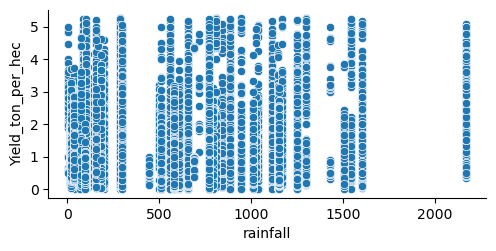

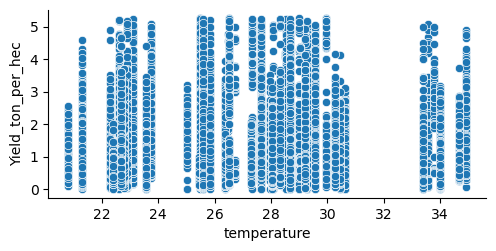

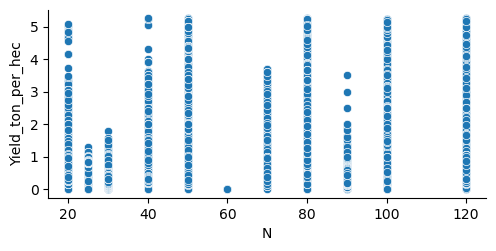

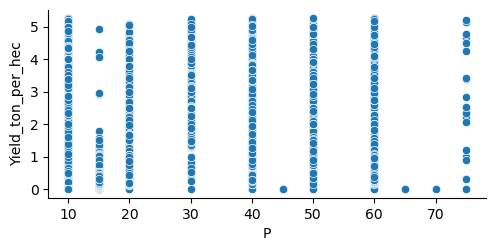

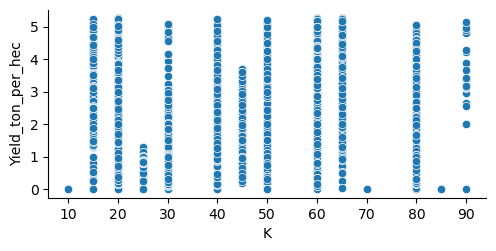

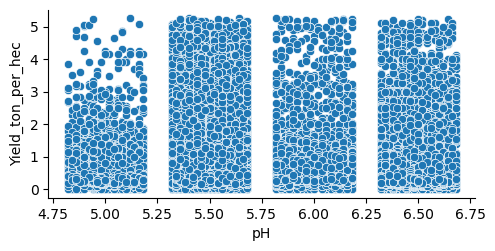

In [151]:
myplot = sns.pairplot(df_CropYieldCombined, x_vars=["rainfall"], y_vars=["Yield_ton_per_hec"], aspect=2)
myplot = sns.pairplot(df_CropYieldCombined, x_vars=["temperature"], y_vars=["Yield_ton_per_hec"], aspect=2)
myplot = sns.pairplot(df_CropYieldCombined, x_vars=["N"], y_vars=["Yield_ton_per_hec"], aspect=2)
myplot = sns.pairplot(df_CropYieldCombined, x_vars=["P"], y_vars=["Yield_ton_per_hec"], aspect=2)
myplot = sns.pairplot(df_CropYieldCombined, x_vars=["K"], y_vars=["Yield_ton_per_hec"], aspect=2)
myplot = sns.pairplot(df_CropYieldCombined, x_vars=["pH"], y_vars=["Yield_ton_per_hec"], aspect=2)

## Features and Target Selection
We have identified Rainfall, Temperature, Nitrogen, Phosphorous, Potassium, pH, State Names, Crop Type, Crop as our features, and Yield as our target.

The reason for selecting these features is as follows:
- Significant correlation with crop yield
    - **Rainfall:** Adequate rainfall is crucial for plant growth as it contributes to soil moisture which provides the water for photosynthesis, nutrient uptake, and overall plant health. Insufficient or excess rainfall can lead to water stress, affecting crop yield negatively. 

    - **Temperature:** Temperature influences the rate of plant growth, development, and metabolism. Extreme temperatures (either too high or too low) can disrupt physiological processes in plants, impacting their productivity. Different crops have specific temperature requirements for optimal growth, causing temperature to be a crucial determinant of yield.

    - **Nitrogen (N), Phosphorus (P), Potassium (K):** These are primary macronutrients essential for plant growth. Nitrogen aids in leaf and stem development, phosphorus is crucial for root development and flowering, and potassium contributes to overall plant health, disease resistance, and fruit quality. Deficiencies or imbalances in these nutrients can limit crop growth and yield.

    - **pH:** Soil pH is the degree of alkalinity or acidity of soils. When pH is too low or too high, chemical reactions can alter the nutrient availability and biological activity in soils. Most fruits and vegetables grow best when soil pH is slightly acidic to neutral, or between 5.5 and 7.0 as evident in the graph above. Hence, pH is crucial in influencing crop yield.

    - **State Names:** The state where crops are cultivated can influence yield due to variations in climate, soil types, and local agricultural practices. 

    - **Crop Type:** This is used to classify the crops based on the month inputted by user in our Predict_Yield( ) function. 

- Measurable and quantifiable




In [153]:
#Extract Feature Titles
feature_title_list  = [col for col in df_CropYieldCombined.columns if col != 'Yield_ton_per_hec']

# Extract the features and the targets 
df_features, df_target = get_features_targets(df_CropYieldCombined,feature_title_list,["Yield_ton_per_hec"])


## Multiple Linear Regression Model

- Linear regression is a linear model, e.g. a model that assumes a linear relationship between the features (x) and the target (y). More specifically, that y can be calculated from a linear combination of the features (x).
$$y = \beta_0 + \beta_1 x$$

- For this specific task, we will be using a multiple linear regression where we have n features and 1 target.
$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + ... + \hat{\beta}_n x_n$$

- The cost function that we will be using is:
$$J(\hat{\beta}_0, \hat{\beta}_1, ... \hat{\beta}_n) = \frac{1}{2m}(\mathbf{\hat{y}}-\mathbf{y})^T\times (\mathbf{\hat{y}}-\mathbf{y})$$

- And using gradient descent, we will be updating the weights and bias on every iteration using this function:
$$\mathbf{\hat{b}} = \mathbf{\hat{b}} - \alpha \frac{1}{m}\mathbf{X}^T \times (\mathbf{\hat{y}} - \mathbf{y})$$

- The metric we will be using to evaluate our model:
    - Mean Squared Error
    $$MSE = \frac{1}{n}\Sigma_{i=1}^n(y^i - \hat{y}^i)^2$$

### LinearRegressionModel Class 

- **Initialization**
    - lr: Learning rate
    - epochs: Number of training epochs (iterations)
    - weights: Initial weights for the linear regression model
    - means: Mean values for normalization
    - stds: Standard deviation values for normalization
    - columns_to_normalize: Columns of df_features_train to be normalized
    
<br>

- **Fit Method**
    - takes in array X and array target_train as inputs
    - calls the gradient_descent_linreg( ) function 
    - updates and returns the model parameters self._beta and self._J_storage

<br>

- **Predict Method**
    - takes in df_features_test as input
    - calls the predict_linreg( ) function
    - returns predictions 

<br>

- **Mse Method**
    - takes in target and df_features_test 
    - calls the Predict Method
    - calls mean_squared_error( ) function
    - returns mse value

<br>

- **Plot_beta Method**
    - converts beta to a list
    - plots horizontal bar graph of features against beta values using the Seaborn library

<br>

- **Plot_training_error Method**
    - plots the stored cost function values (self._J_storage) against iterations (self.epochs) using Matplotlib


In [135]:
#alpha = lr; iterations = epochs; beta = weights


class LinearRegressionModel:
    def __init__(self,lr,epochs,weights,means,stds,columns_to_normalize):
        self.lr = lr
        self.epochs = epochs
        self.weights = weights
        self.bias = None
        self._beta = None
        self._J_storage = None
        self._means = means
        self._stds = stds
        self._columns_to_normalize = columns_to_normalize

    def fit(self, X, target_train):
        #call gradient descent function
        self._beta, self._J_storage = gradient_descent_linreg(X, target_train, self.weights, self.lr, self.epochs)
        return self._beta, self._J_storage    
        
    def predict(self, df_features_test):
        pred = predict_linreg(df_features_test, self._beta, self._means, self._stds, self._columns_to_normalize)
        return pred

    def mse(self, target, df_features_test):
        pred = self.predict(df_features_test)
        df_target = prepare_target(target)
        mse = mean_squared_error(df_target, pred)
        return mse

    def plot_beta(self):
        beta_list = self._beta.tolist()
        beta_data = beta_list[1:]
        newBetaList = [item for sublist in beta_data for item in sublist]
        # plt.barh(feature_title_list[39:43], newBetaList[39:43])
        plt.figure(figsize=(10, 35))
        sns.barplot(x=newBetaList[0:110], y=feature_title_list[0:110])
        plt.xlabel('Beta Values')
        plt.ylabel('Environmental Variables ')
        plt.title('Environmental Variables Vs Beta Values')
        plt.show()

    def plot_training_error(self):
        plt.plot(self._J_storage)

## Training Model 1

Normalization has been applied to only certain columns and not categorical columns

### Splitting and preparing

In [136]:
# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize using z normalization
columns_to_normalize = ['rainfall', 'temperature', 'N', 'P', 'K', 'pH']
df_features_train_z,model1_means,model1_stds = normalize_z(df_features_train, columns_to_normalize)

#prepare X and target to nummpy arrays 
X = prepare_feature(df_features_train_z)
target_train = prepare_target(df_target_train)
print(X.shape)

(65354, 92)


### Applying gradient descent and Evaluating using MSE 

In [137]:
regressor1 = LinearRegressionModel(lr=0.1, epochs=1500, weights=np.zeros((92,1)),means=model1_means,stds=model1_stds,columns_to_normalize=columns_to_normalize)
beta, J_storage = regressor1.fit(X, target_train)

# Make predictions on the test features
predictions1 = regressor1.predict(df_features_test)
regressor1.mse(df_target_test, df_features_test)

0.43497585513751097

### Analysis and Visualization of Training Model 1
- Plotting Cost vs Iterations

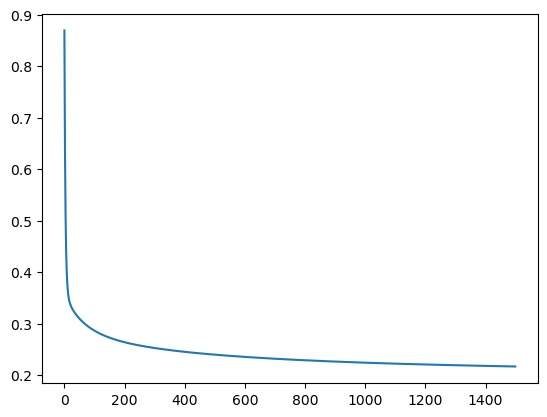

In [138]:
regressor1.plot_training_error()

- Bar Graph of Beta Values for Environmental Variables 

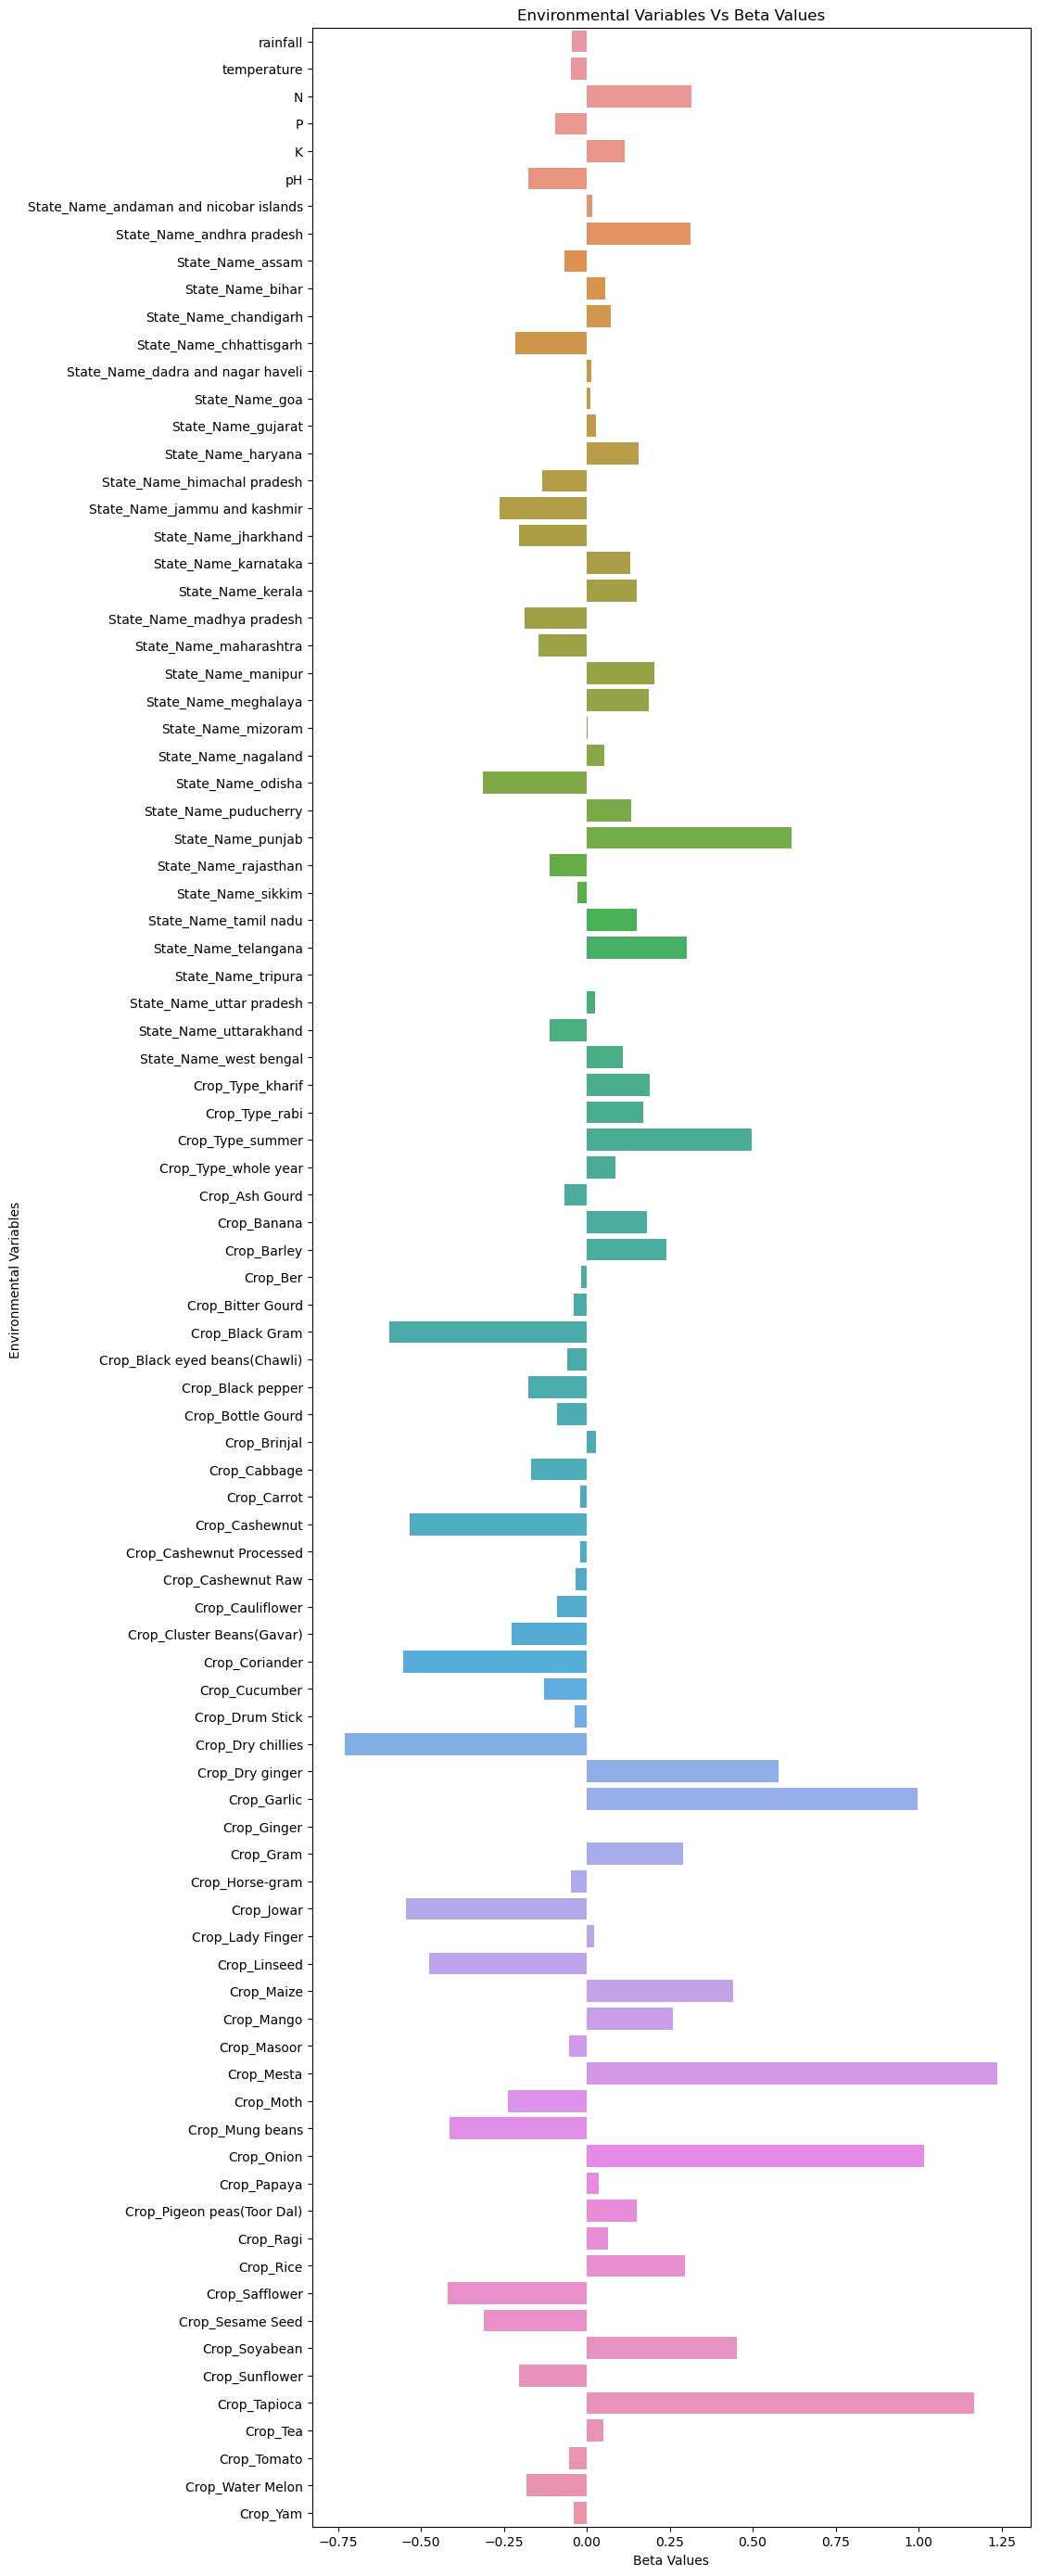

In [139]:
regressor1.plot_beta()

## Training Model 2

### Pre-processing data

- We realized there is a disproportionate amount of crops for each state (eg. uttar pradesh - 12570, goa - 7)
- We decided on a number of 2430 as the base amount of crops using gujarat as the base line
- Drop rows corresponding to the states with crop count lower than 2430 threshold
- Create sample_rows() function to randomly sample 2400 crops for all other states that have more than 2430 data points

uttar pradesh                  12570
madhya pradesh                  9439
karnataka                       8856
bihar                           8592
odisha                          6210
rajasthan                       6010
maharashtra                     4970
tamil nadu                      4796
assam                           4284
west bengal                     3949
andhra pradesh                  3709
chhattisgarh                    3636
telangana                       2686
gujarat                         2430
haryana                         1775
uttarakhand                     1714
nagaland                        1225
himachal pradesh                 964
punjab                           809
meghalaya                        795
jharkhand                        747
kerala                           690
jammu and kashmir                664
manipur                          431
mizoram                          416
tripura                          358
puducherry                       295
s

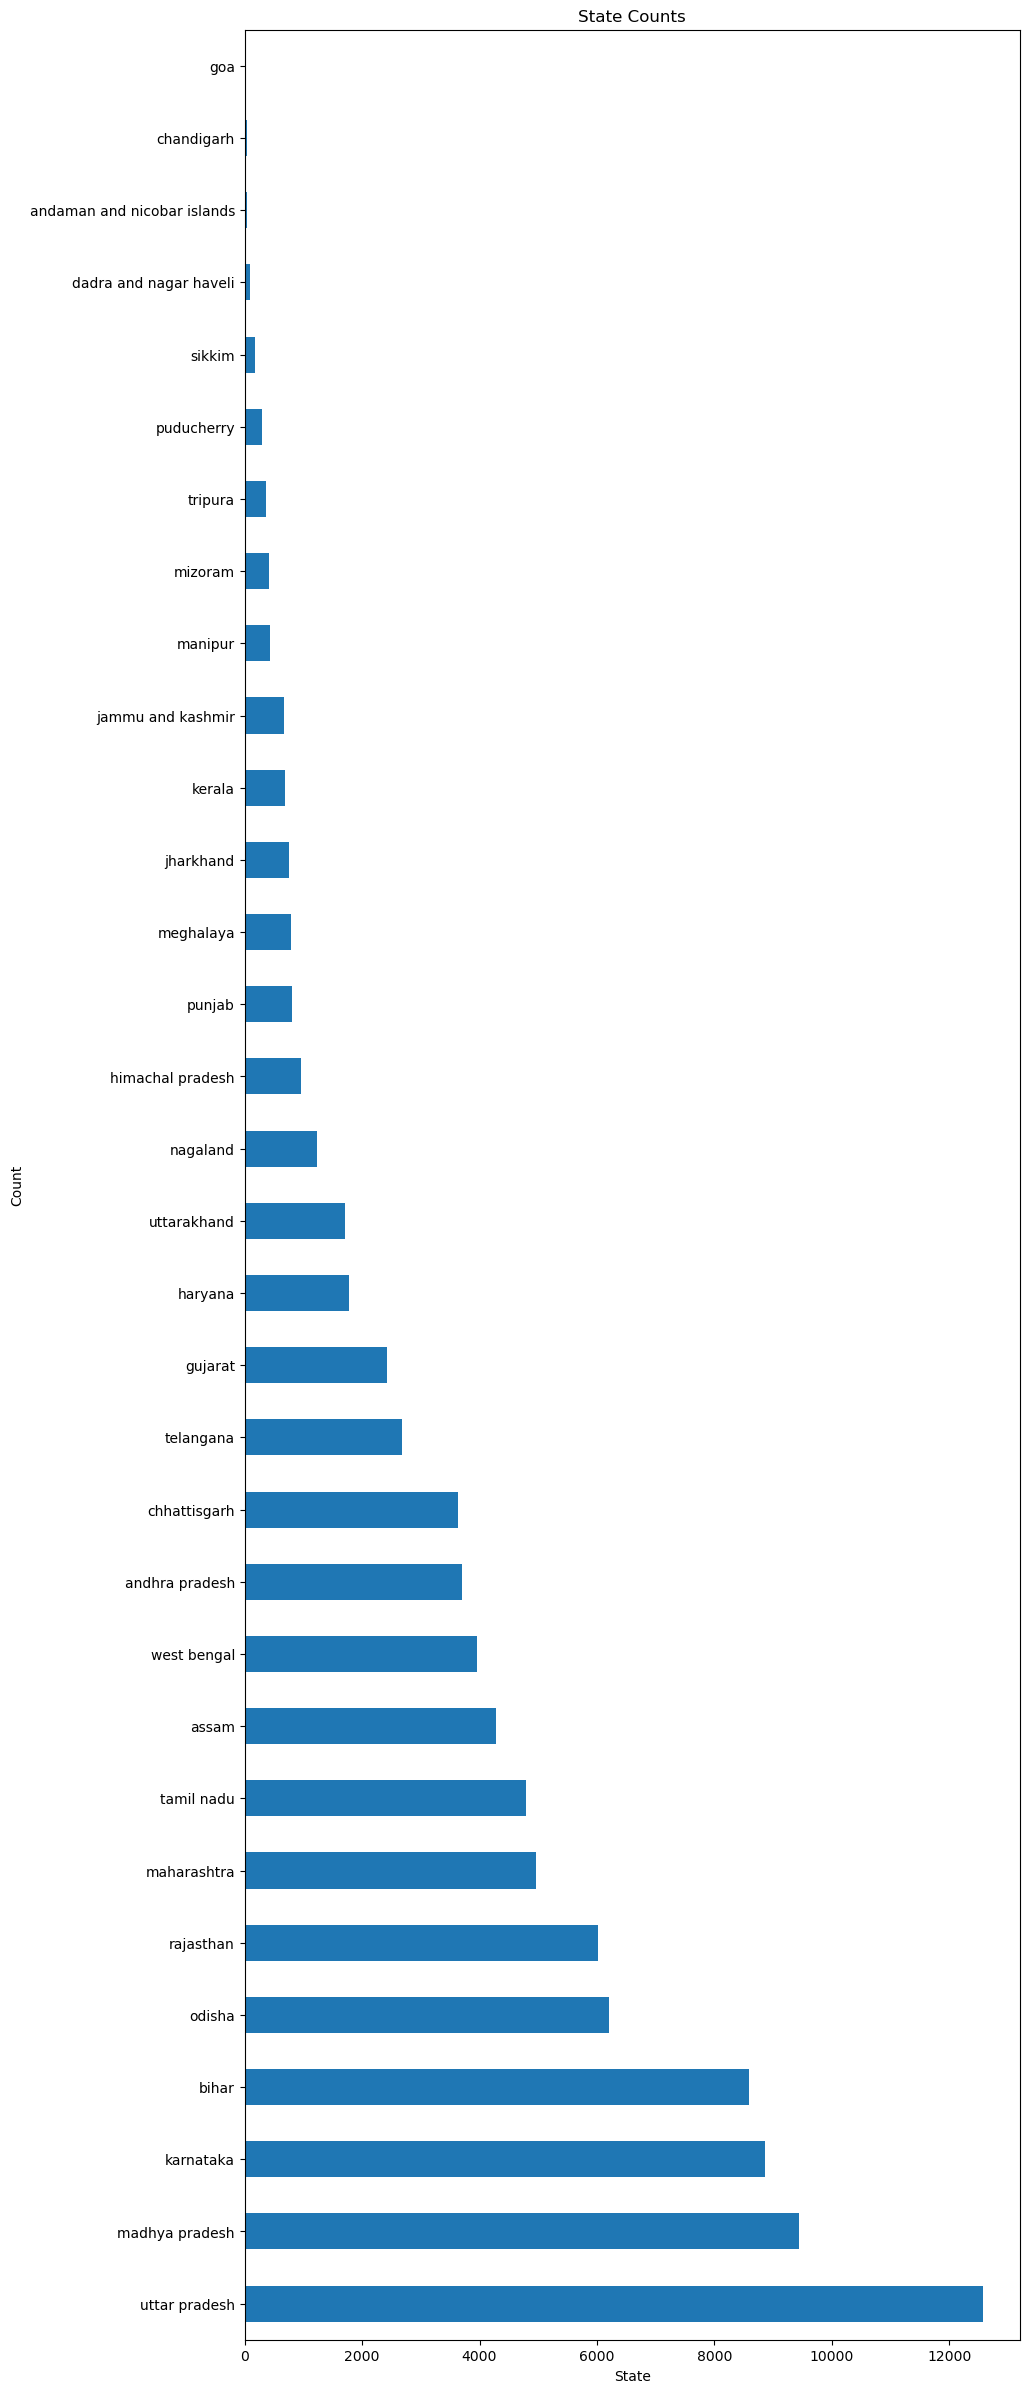

In [140]:
# Read the CSV file
df_CropYieldCombined = pd.read_csv("Crop_Yield_Combined_NoDummy_NoOutl.csv")
df_CropYieldCombined_Model2 = df_CropYieldCombined.copy()

state_counts = df_CropYieldCombined_Model2['State_Name'].value_counts()
print(state_counts)

# Plot Crop Count
plt.figure(figsize=(10, 30))  # Adjust the figure size if needed
state_counts.plot(kind='barh')
plt.title('State Counts')
plt.xlabel('State')
plt.ylabel('Count')  # Rotate x-axis labels for better readability
plt.show()

In [141]:
states_to_drop = state_counts[state_counts < 2430].index

df_CropYieldCombined_Model2 = df_CropYieldCombined_Model2[df_CropYieldCombined_Model2["State_Name"].isin(states_to_drop) == False]

# Define a function to sample rows within each group
def sample_rows(group):
    if len(group) >= 2430:
        return group.sample(2430)
    else:
        return group

# Use groupby and apply the function to sample rows for each group
df_CropYieldCombined_Model2 = df_CropYieldCombined_Model2.groupby("State_Name", group_keys=False, sort=False).apply(sample_rows)
state_counts = df_CropYieldCombined_Model2['State_Name'].value_counts()
print(state_counts)

df_CropYieldCombined_Model2.drop(['Area_in_hectares', 'Production_in_tons'], axis=1, inplace=True)
# Convert categories to dummy variables
df_CropYieldCombined_Model2_NoCat = pd.get_dummies(df_CropYieldCombined_Model2,dtype=int)
# Move y column to last
df_CropYieldCombined_Model2_NoCat["Yield_ton_per_hec"] = df_CropYieldCombined_Model2_NoCat.pop("Yield_ton_per_hec")
# df_CropYieldCombined_Model2_NoCat.to_csv('Crop_Yield_Combined_Model2_NoOutl.csv', index=False)

andhra pradesh    2430
assam             2430
bihar             2430
gujarat           2430
karnataka         2430
madhya pradesh    2430
maharashtra       2430
odisha            2430
rajasthan         2430
tamil nadu        2430
telangana         2430
uttar pradesh     2430
west bengal       2430
chhattisgarh      2430
Name: State_Name, dtype: int64


### Reading Processed Data

In [142]:
# Read the CSV file
df_CropYieldCombined_Model2 = pd.read_csv("Crop_Yield_Combined_Model2_NoOutl.csv")

### Splitting and preparing 

In [143]:
#Extract Feature Titles
feature_title_list  = [col for col in df_CropYieldCombined_Model2.columns if col != 'Yield_ton_per_hec']

# Extract the features and the targets 
df_features, df_target = get_features_targets(df_CropYieldCombined_Model2,feature_title_list,["Yield_ton_per_hec"])

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize using z normalization
columns_to_normalize = ['rainfall', 'temperature', 'N', 'P', 'K', 'pH']
df_features_train_z,model2_means,model2_stds= normalize_z(df_features_train,columns_to_normalize)

#prepare X and target to nummpy arrays 
X = prepare_feature(df_features_train_z)
target_train = prepare_target(df_target_train)
print(X.shape)

(23814, 72)


### Applying gradient descent and Evaluating model using MSE
- As compared to our Model 1 which has a MSE of 0.43497585513751097, this model has an MSE of 0.40925256217497274. There has been a slight improvement

In [144]:
regressor2 = LinearRegressionModel(lr=0.1, epochs=1500, weights=np.zeros((72,1)),means=model2_means,stds=model2_stds,columns_to_normalize=columns_to_normalize)
beta, J_storage = regressor2.fit(X, target_train)

# Make predictions on the test features
predictions2 = regressor2.predict(df_features_test)
regressor2.mse(df_target_test, df_features_test)

0.40925256217497274

### Analysis and visualization of Model 2
- Plotting Cost vs Iterations

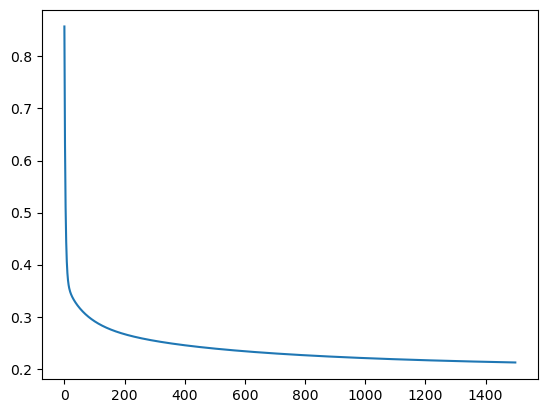

In [145]:
regressor2.plot_training_error()

- Bar Graph of Beta Values for Environmental Variables

Evidently, beta values for states are now more similar and comparable

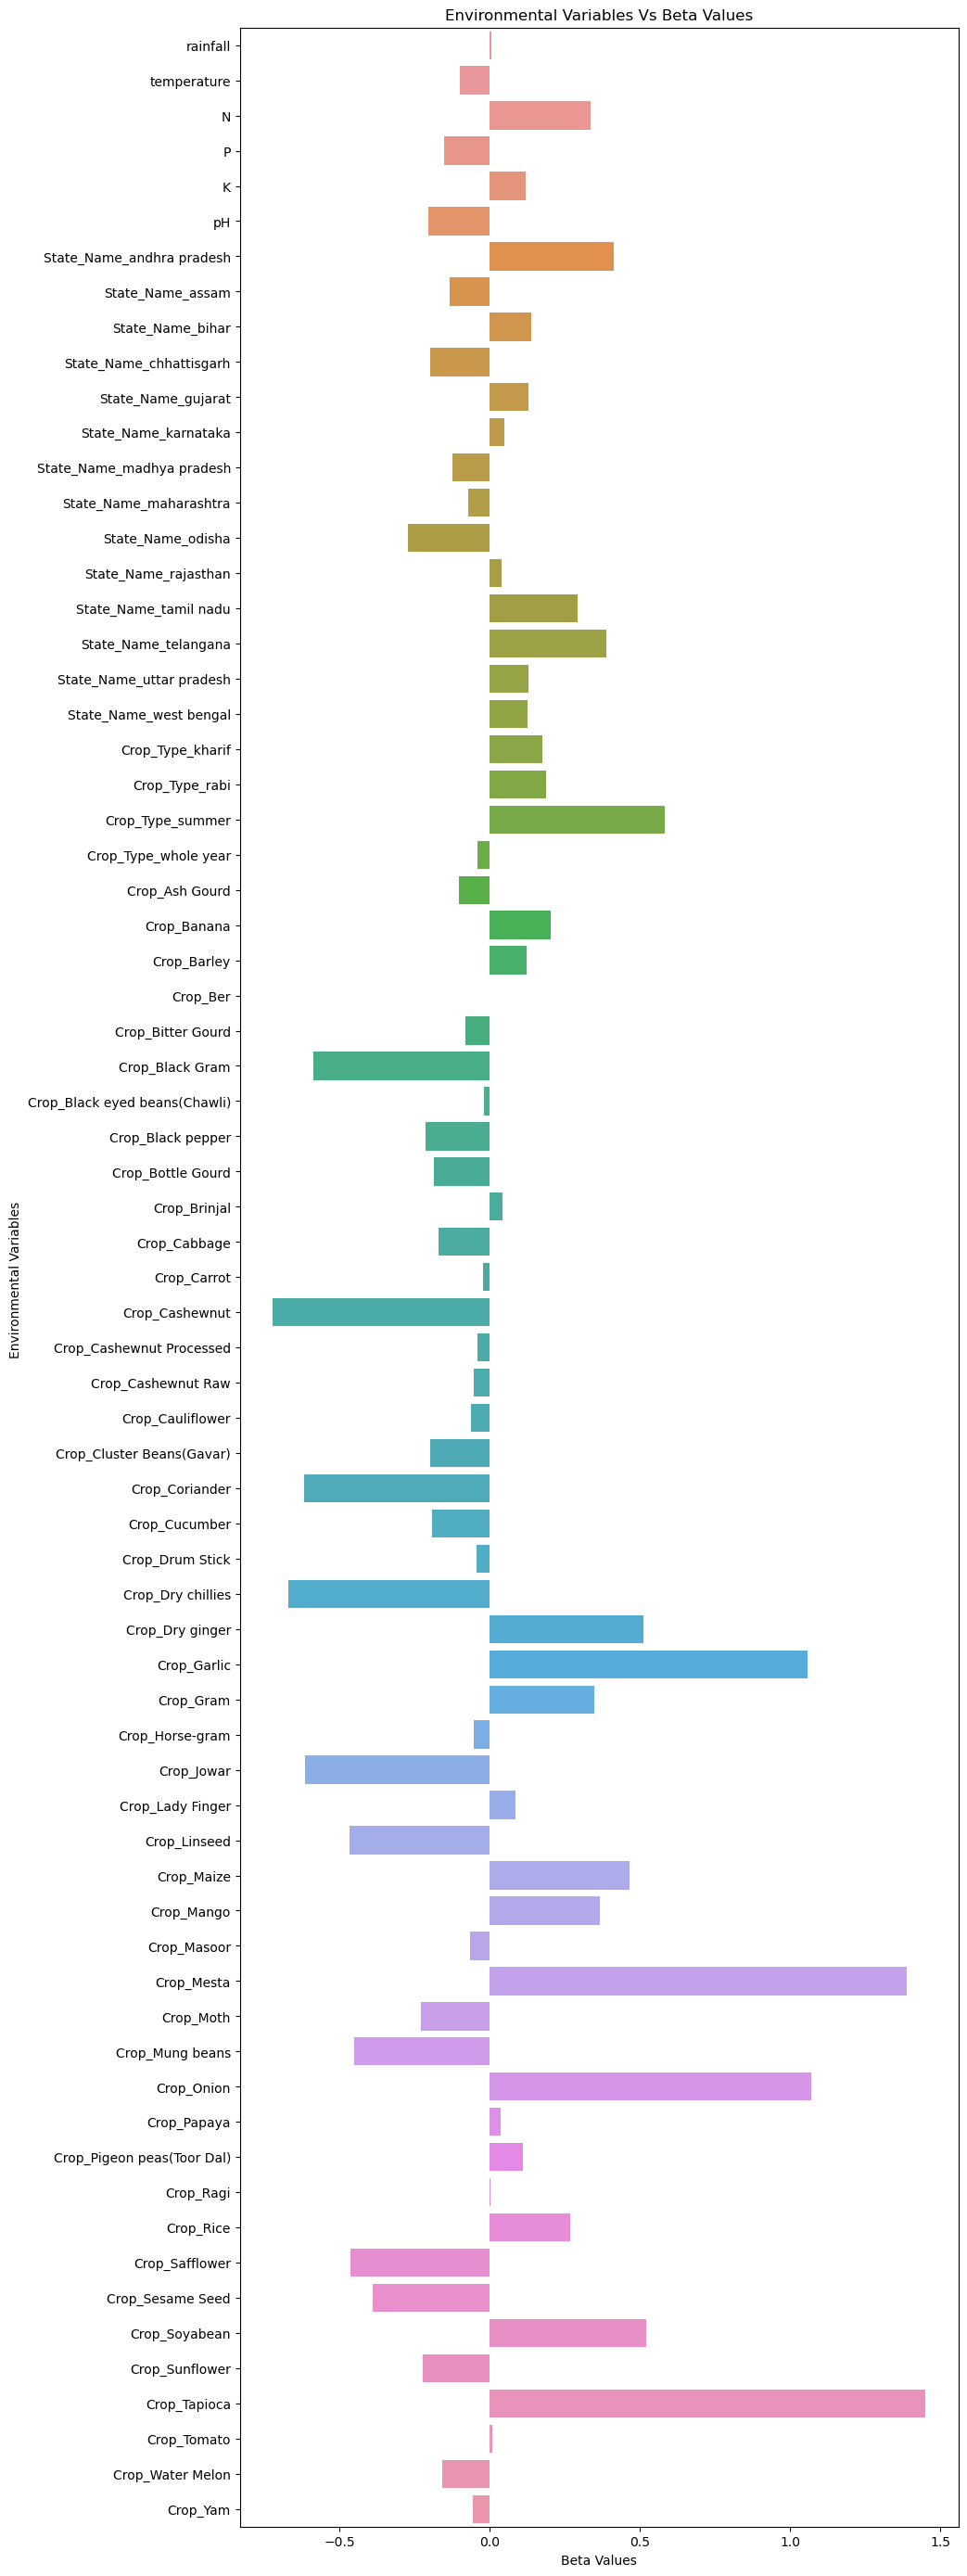

In [146]:
regressor2.plot_beta()

## Training Model 3

### Pre-processing data
- We realized there is also a disproportionate amount of crops for each crop (eg. rice - 3733, ginger - 1)
- We decided on a number of 1066 as the base amount using Linseed as the base line 
- Drop crops with crop count less than 1066 
- Create sample_rows() function to randomly sample 1066 crops for all other crops that have more than 1066 data points

Rice                        3733
Maize                       3031
Mung beans                  2733
Black Gram                  2655
Sesame Seed                 2384
Jowar                       2196
Pigeon peas(Toor Dal)       2090
Gram                        1875
Dry chillies                1814
Sunflower                   1361
Ragi                        1171
Horse-gram                  1165
Linseed                     1066
Coriander                    848
Masoor                       841
Soyabean                     718
Barley                       685
Garlic                       554
Dry ginger                   424
Safflower                    404
Onion                        384
Mesta                        280
Cluster Beans(Gavar)         264
Cashewnut                    254
Moth                         241
Tapioca                      151
Black pepper                 146
Mango                         83
Tomato                        56
Cucumber                      51
Lady Finge

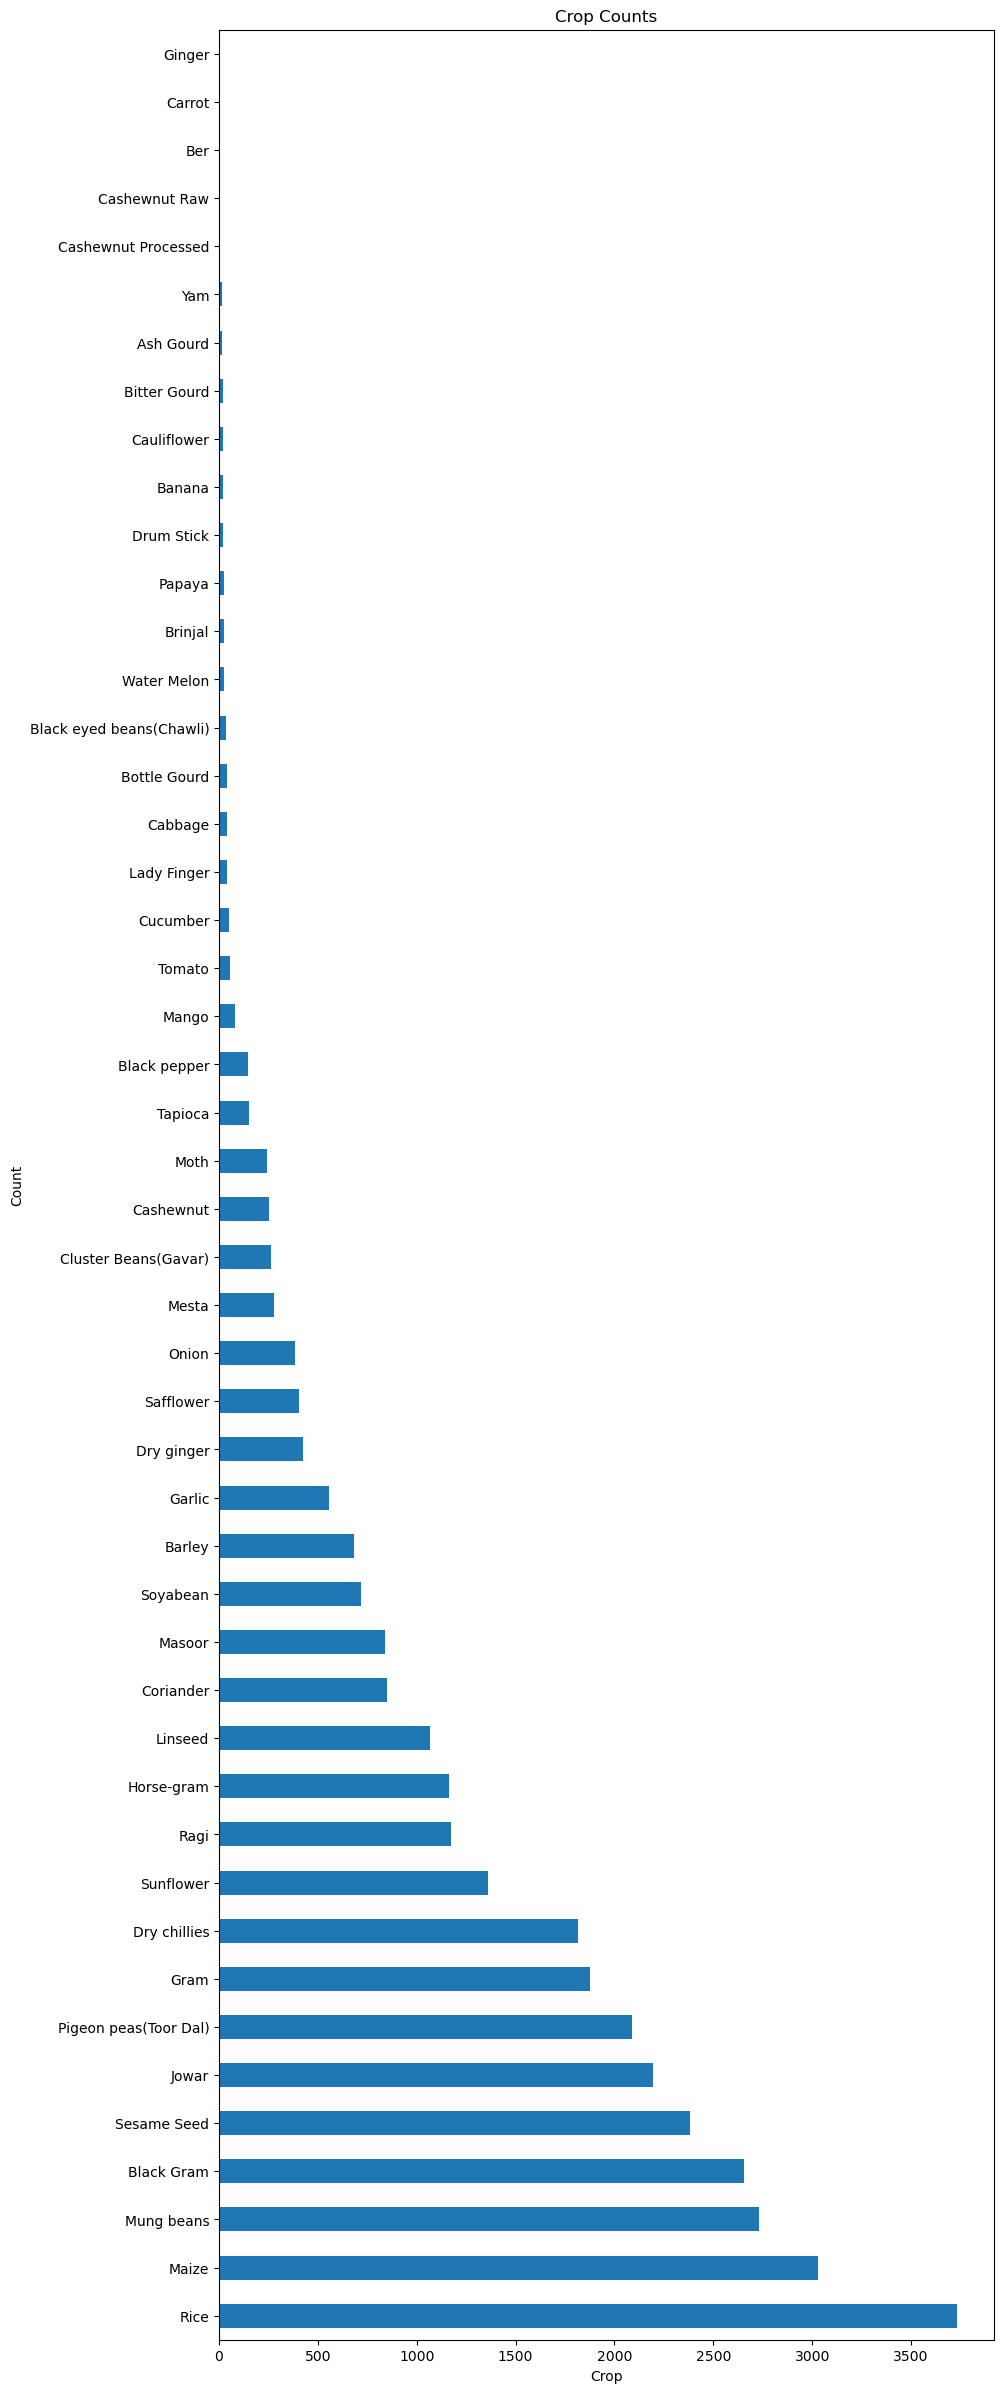

In [147]:
# Read the CSV file
df_CropYieldCombined = pd.read_csv("Crop_Yield_Combined_Model2_NoOutl_NoDummy.csv")
df_CropYieldCombined_Model3 = df_CropYieldCombined.copy()

crop_counts = df_CropYieldCombined_Model3['Crop'].value_counts()
print(crop_counts)

# PLot Crop Count
plt.figure(figsize=(10, 30))  # Adjust the figure size if needed
crop_counts.plot(kind='barh')
plt.title('Crop Counts')
plt.xlabel('Crop')
plt.ylabel('Count')  # Rotate x-axis labels for better readability
plt.show()

In [148]:
crops_to_drop = crop_counts[crop_counts < 1066].index

df_CropYieldCombined_Model3 = df_CropYieldCombined_Model3[df_CropYieldCombined_Model3["Crop"].isin(crops_to_drop) == False]
# Define a function to sample rows within each group
def sample_rows(group):
    if len(group) >= 1066:
        return group.sample(1066)
    else:
        return group
        
# Use groupby and apply the function to sample rows for each group
df_CropYieldCombined_Model3 = df_CropYieldCombined_Model3.groupby("Crop", group_keys=False, sort=False).apply(sample_rows)
crop_counts = df_CropYieldCombined_Model3['Crop'].value_counts()
print(crop_counts)

df_CropYieldCombined_Model3.drop(['Area_in_hectares', 'Production_in_tons'], axis=1, inplace=True)
#convert categories to dummy variables
df_CropYieldCombined_Model3_NoCat = pd.get_dummies(df_CropYieldCombined_Model3,dtype=int)
#move y column to last
df_CropYieldCombined_Model3_NoCat["Yield_ton_per_hec"] = df_CropYieldCombined_Model3_NoCat.pop("Yield_ton_per_hec")
# df_CropYieldCombined_Model3_NoCat.to_csv('Crop_Yield_Combined_Model3_NoOutl.csv', index=False)

Rice                     1066
Ragi                     1066
Mung beans               1066
Sunflower                1066
Jowar                    1066
Horse-gram               1066
Maize                    1066
Pigeon peas(Toor Dal)    1066
Black Gram               1066
Gram                     1066
Dry chillies             1066
Sesame Seed              1066
Linseed                  1066
Name: Crop, dtype: int64


### Splitting and Preparing

In [149]:
# Read the CSV file
df_CropYieldCombined_Model3 = pd.read_csv("Crop_Yield_Combined_Model3_NoOutl.csv")

#Extract Feature Titles
feature_title_list  = [col for col in df_CropYieldCombined_Model3.columns if col != 'Yield_ton_per_hec']

# Extract the features and the targets 
df_features, df_target = get_features_targets(df_CropYieldCombined_Model3,feature_title_list,["Yield_ton_per_hec"])

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize using z normalization
columns_to_normalize = ['rainfall', 'temperature', 'N', 'P', 'K', 'pH']
df_features_train_z,model3_means,model3_stds= normalize_z(df_features_train,columns_to_normalize)

#prepare X and target to nummpy arrays 
X = prepare_feature(df_features_train_z)
target_train = prepare_target(df_target_train)
print(X.shape)

(9701, 38)


### Applying gradient descent and Evaluating using MSE 
- As compared to our Model 2 which has a MSE of 0.40925256217497274, this model has an MSE of 0.3029984877471842. There has been a significant improvement
- Changing parameters such as learning rate changes the MSE slightly as show in the commented code. 0.30439893485796354 -> 0.30302135999213536

In [158]:
# regressor3 = LinearRegressionModel(lr=0.1, epochs=1500, weights=np.zeros((38,1)),means=model3_means,stds=model3_stds,columns_to_normalize=columns_to_normalize)
# beta3, J_storage3 = regressor3.fit(X, target_train)
# # Make predictions on the test features
# predictions3 = regressor3.predict(df_features_test)
# regressor3.mse(df_target_test, df_features_test)
# # MSE 0.30439893485796354

# regressor3 = LinearRegressionModel(lr=0.3, epochs=2500, weights=np.zeros((38,1)),means=model3_means,stds=model3_stds,columns_to_normalize=columns_to_normalize)
# beta3, J_storage3 = regressor3.fit(X, target_train)
# # Make predictions on the test features
# predictions3 = regressor3.predict(df_features_test)
# regressor3.mse(df_target_test, df_features_test)
# # MSE 0.30302135999213536

regressor3 = LinearRegressionModel(lr=0.5, epochs=2500, weights=np.zeros((38,1)),means=model3_means,stds=model3_stds,columns_to_normalize=columns_to_normalize)
beta3, J_storage3 = regressor3.fit(X, target_train)

# Make predictions on the test features
predictions3 = regressor3.predict(df_features_test)
regressor3.mse(df_target_test, df_features_test)
# MSE 0.3029984877471842

0.3029984877471842

### Analysis and visualization of Model 3
- Plotting Cost vs Iterations

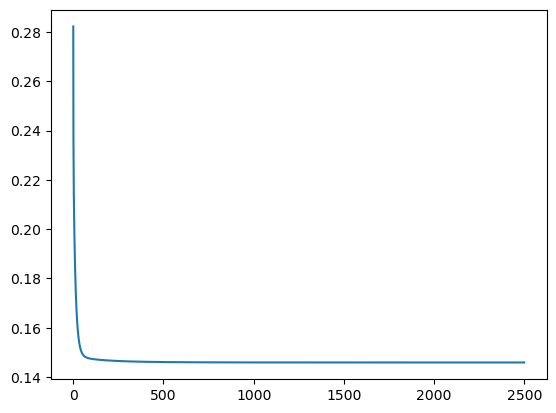

In [120]:
regressor3.plot_training_error()

- Bar Graph of Beta Values for Environmental Variables

Evidently, the beta values for crops are now more similar and comparable

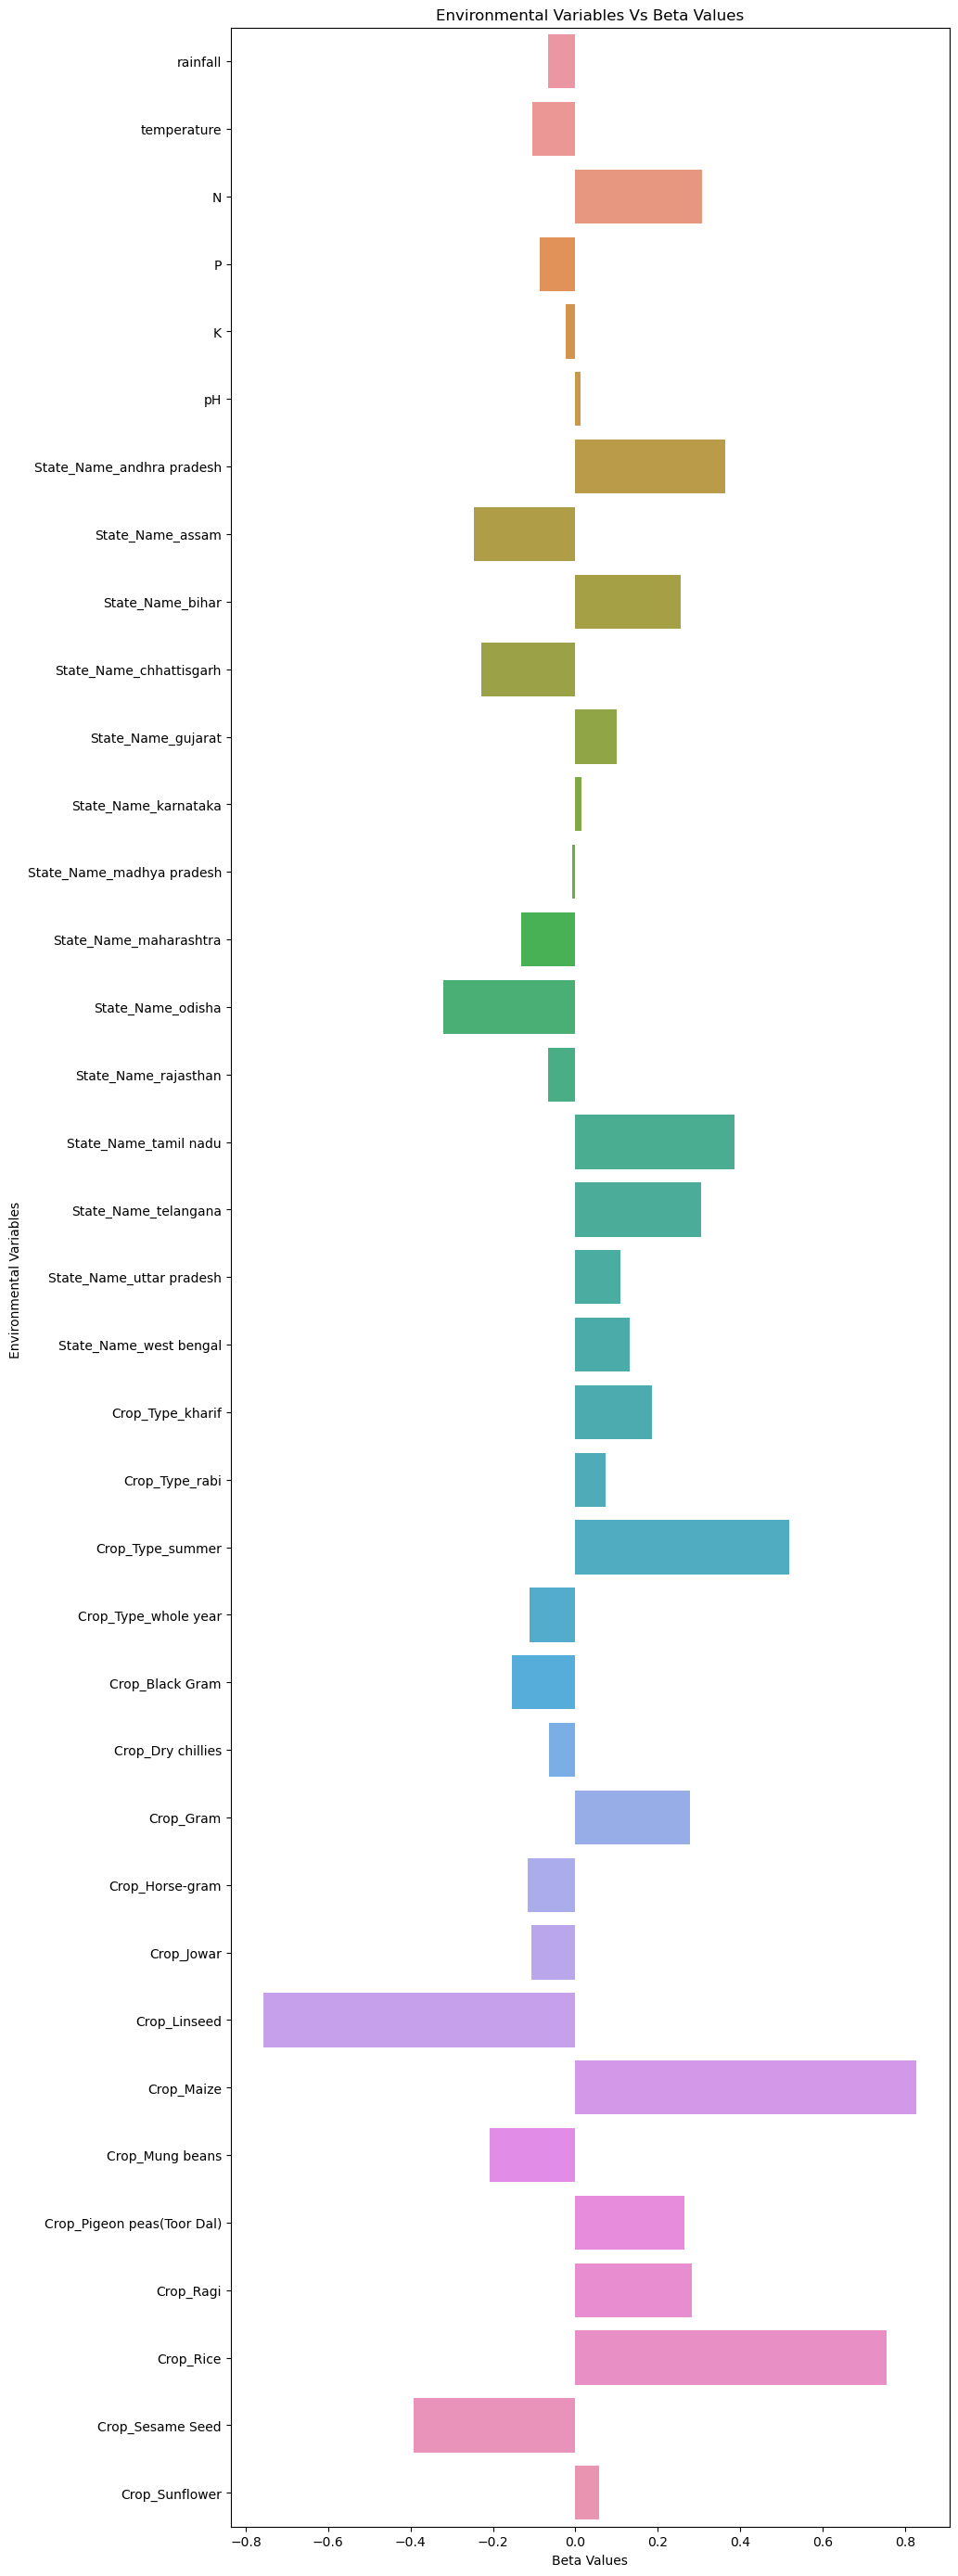

In [121]:
regressor3.plot_beta()

#### Saving best Model Weights
The trained beta values and mean/standard deviation were stored in a json file for use in our prediction function

In [122]:
#save best model as json
beta3_list = beta3.tolist()
model3_means_list = model3_means.tolist()
model3_stds_list = model3_stds.tolist()
data = {"beta": beta3_list, "J_storage": J_storage3,"means":model3_means_list, "stds":model3_stds_list}
data = {
    "beta": beta3_list,
    "J_storage": J_storage,
    "means": {"columns": model3_means.index.tolist(), "values": model3_means_list},
    "stds": {"columns": model3_stds.index.tolist(), "values": model3_stds_list}
}
with open('model3(best).json', 'w') as file:
    json.dump(data, file)

## Predict_Yield Function 

Users (Farmers) can input the soil conditions, their state name, and the month into this function to know the predicted yield for various crops. This will enable them to make informed decisions on the type of crop to plant for higher crop production 

In [152]:
#---------------------Functions start---------------------
#To get Crop Type
def enterCropTye(user_inp_dict,month_inp):
    crop_types = ['Crop_Type_kharif', 'Crop_Type_rabi', 'Crop_Type_summer', 'Crop_Type_whole year']
    if month_inp in [3,4,5]:
        user_inp_dict['Crop_Type_kharif'] = 1
        user_inp_dict['Crop_Type_whole year'] = 1
    elif month_inp in [12,1,2]:
        user_inp_dict['Crop_Type_rabi'] = 1
        user_inp_dict['Crop_Type_whole year'] = 1
    elif month_inp in [6,7,8]:
        user_inp_dict['Crop_Type_summer'] = 1
        user_inp_dict['Crop_Type_whole year'] = 1
    else:
        user_inp_dict['Crop_Type_whole year'] = 1

#To get valid state
def get_valid_state_input(statesList):
    while True:
        # User input state
        user_input_state = input("Enter state name(in India): ")

        # Find the best match and score
        matchResult = process.extractOne(user_input_state, statesList)

        # Check if the score is greater than 85
        if matchResult[1] > 85:
            return "State_Name_" + matchResult[0]
        else:
            print(f"Invalid input. Please try again with a valid state.")
#Print inputs 
def print_result_statements(rainfall, N, P, K, pH, temperature, state, month):
    print(f"\nResult Statements:")
    print(f"Rainfall Conditions: {rainfall}")
    print(f"N Conditions: {N}")
    print(f"P Conditions: {P}")
    print(f"K Conditions: {K}")
    print(f"pH Conditions: {pH}")
    print(f"Temperature Conditions: {temperature}")
    print(f"State: {state}")
    print(f"Month: {month}")

#-----------------functions end---------------------


#Load Data Used for best model
df_Model3_Data = pd.read_csv('Crop_Yield_Combined_Model3_NoOutl.csv')
#extract feature names 
featureColumnNames = df_Model3_Data.columns[:-1]
#create new Datafram with just features;ready to input prediction data
df_Model3_ToUse = pd.DataFrame(columns=featureColumnNames)
statesList = df_Model3_ToUse.columns[df_Model3_ToUse.columns.str.startswith('State_Name')].tolist()
statesList = [col.replace('State_Name_', '') for col in statesList]

# start getting inputs to predict
rainfall_inp = float(input('Enter rainfall conditions:')) 
N_inp = float(input('Enter N conditions:'))
P_inp = float(input('Enter P conditions:'))
K_inp = float(input('Enter K conditions:'))
pH_inp = float(input('Enter pH conditions:'))
temp_input = float(input('Enter temperature conditions:'))
state_inp = get_valid_state_input(statesList)
month_inp = float((input('Enter month:')))
print_result_statements(rainfall_inp, N_inp, P_inp, K_inp, pH_inp, temp_input, state_inp, month_inp)

# create dictionary containing user inputs
user_inp_dict = {}
user_inp_dict['rainfall'] = rainfall_inp
user_inp_dict['N'] = N_inp
user_inp_dict['P'] = P_inp
user_inp_dict['K'] = K_inp
user_inp_dict['pH'] = pH_inp
user_inp_dict[state_inp] = 1

#enter crop_type(which season crop) based on month
enterCropTye(user_inp_dict,month_inp)

#Enter user inputs into df_Model4_ToUse
user_inp_df = pd.DataFrame([user_inp_dict])
df_Model3_ToUse = pd.concat([df_Model3_ToUse,user_inp_df],ignore_index=True)

#Enter use inputs to predict yield for each crop
crop_columns = [col for col in df_Model3_ToUse.columns if col.startswith('Crop_') and not col.startswith('Crop_Type')]

initial_input_row = df_Model3_ToUse.iloc[0]

#add rows corresponding to number of crops
df_Model3_ToUse = pd.concat([df_Model3_ToUse]* (len(crop_columns)),ignore_index=True)
for index in range(len(crop_columns)):
    df_Model3_ToUse.at[index,crop_columns[index]] = 1
df_Model3_ToUse.fillna(0,inplace=True)

# Loading beta values from json file
bestModelWeightsJson = open('model3(best).json')
bestModelWeights = json.load(bestModelWeightsJson)
beta_values = bestModelWeights['beta']

# Convert lists back to pandas Series
means_columns = bestModelWeights['means']['columns']
means_values = bestModelWeights['means']['values']
model3_means = pd.Series(means_values, index=means_columns)

# Convert lists back to pandas Series
stds_columns = bestModelWeights['stds']['columns']
stds_values = bestModelWeights['stds']['values']
model3_stds = pd.Series(stds_values, index=stds_columns)
columns_to_normalize = ['rainfall', 'temperature','N', 'P', 'K', 'pH']

#initiate predicting
pred = predict_linreg(df_Model3_ToUse, beta_values,model3_means,model3_stds,columns_to_normalize)

# Flatten the array
pred_flat = pred.flatten()

# Combine crop_columns and pred_flat into a dictionary
prediction_dict = dict(zip(crop_columns, pred_flat))
sorted_prediction = dict(sorted(prediction_dict.items(), key=lambda item: item[1], reverse=True))


print(f'Prediction: {sorted_prediction}')
sorted_prediction_df = pd.DataFrame(sorted_prediction.items())

# Plotting the bar graph for sorted predictions
plt.figure(figsize=(10, 8))
plt.bar(sorted_prediction_df[0], sorted_prediction_df[1])
plt.xticks(rotation=90)
plt.xlabel('Crop')
plt.ylabel('Predicted Yield')
plt.title('Predicted Yield for Crops')
plt.tight_layout()
plt.show()


NameError: name 'process' is not defined

## Conclusion

- Metric Evaluation
    - We have chosen to use Mean Squared Error (MSE) as our metric to accurately evaluate our model. MSE is a measure of how close a fitted line is to data points. The smaller the MSE, the closer the fit is to the data. The presence of outliers can greatly affect the MSE value, hence we removed outliers during preliminary cleaning of the dataset, allowing this metric to be suitable for our model evaluation. 

        Training Model 1 (MSE - 0.43497585513751097): This model represents the baseline performance without any modifications. It's probable that the dataset used in Model 1 might have imbalances or inconsistencies in sampling, resulting in the model being trained on data that doesn't fully represent the diversity of conditions across different states or crop types. The MSE of 0.435 suggests a certain level of discrepancy between predicted and actual values.

        Training Model 2 (MSE - 0.40925256217497274): In Model 1, the dataset has variations in the number of samples for different states. This imbalance can lead the model to be more biased towards states with a larger number of samples while neglecting or underrepresenting the conditions and characteristics of states with fewer samples. Hence, by ensuring that each state contributes an equal number of samples (2430), Model 2 could train for a more balanced and representative dataset, resulting in a more accurate prediction of crop yield as evident in a lower MSE.

        Training Model 3 (MSE - 0.3029984877471842): Further standardizing the number of sampled crops for each crop type refines the dataset even more. This adjustment allows the model to capture variations specific to different crop types, providing a more detailed understanding of how various crops respond to different conditions. Consequently, this model exhibits the lowest MSE of 0.303, implying enhanced predictive performance due to the increased granularity in considering crop-specific factors.

        The decrease in MSE across the models reflects the models' increased ability to capture underlying patterns and relationships between features and crop yield. By systematically refining the dataset to reflect more diverse conditions and considering the specifics of different crops, each model iteration improves its ability to make accurate predictions, resulting in lower MSE values.

- Result Discussion
    
    Using the trained beta, means, stds values from Training Model 3, we were able to create a function that can predict the yield for all the crops in the dataset based on the user inputted soil conditions, state name and month values. 
    
    **Limitations:**
    Linear regression model is not the most appropriate model to be used in our case of analyzing soil conditions against yield due to the following reasons:
    
    - **Assumption of Linearity:** Linear regression assumes a linear relationship between the independent variables (soil conditions, states, crop types, and crops) and the dependent variable (yield). 
    
    - **Multicollinearity:** Linear regression also assumes that the independent variables are not highly correlated with each other (multicollinearity). However, in our case, different soil conditions may be interrelated, leading to multicollinearity issues that can affect the stability and interpretability of the model. Hence, the relationship between soil conditions and crop yield may involve nonlinearities, interactions, and other complex patterns that linear models may struggle to represent accurately.
    


## Video Link